We want to be able to find abundance values for each KO or ORF across samples. 

some helper functions below

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

DATDIR = '/projects/p32818/metagenomic_data/data'

"""
get_filepath
input: prefix (sample), file_type (abundance .bed or annotation .tsv)
output: a filepath string
"""
def get_filepath(prefix, file_type):
    base_path = '/projects/p32818/metagenomic_data/data'
    if file_type == 'annotation':
        filename = f"{prefix}.coassembly_ORFid_1stClusterDB_2ndClusterDB_KO_annotations_250316.tsv"
    elif file_type == 'abundance':
        filename = f"{prefix}_all_samples_ORF_count_regions_rm0_ORF_ID_changed.bed"
    else:
        raise ValueError("file_type must be either 'annotation' or 'abundance'")
    
    return f'{base_path}/{filename}'

"""
get_clustered_orfs
input: filepath, KO number
output: a list of cluster IDs which correspond to that KO in a given sample
"""
def find_clustered_orfs(file_path, ko_number):
    df = pd.read_csv(file_path, sep='\t', header=None)
    matching_orfs = df[df[3] == ko_number][2].tolist()
    return matching_orfs

"""
find_orfs
input: filepath, KO number
output: a list of unclostered ORFs which correspond to that KO in a given sample
"""
def find_orfs(file_path, ko_number):
    df = pd.read_csv(file_path, sep='\t', header=None)
    matching_orfs = df[df[3] == ko_number][0].tolist()
    return matching_orfs

"""
find_orfs_from_cluster
input: a cluster ID
output: all corresponding ORFs 
"""
def find_orfs_from_cluster(cluster):
    prefixes = ['T0', 'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
    orfs = []
    for prefix in prefixes: 
        FPATH = get_filepath(prefix, 'annotation')
        df = pd.read_csv(FPATH, sep='\t', header=None)
        temp = df[df[2] == cluster][0].tolist()
        orfs.extend(temp)
    return orfs

"""
find_cluster_from_orf
input: a cluster ID
output: all corresponding ORFs 
"""
def find_cluster_from_orf(orf):
    prefix = orf.split('.')[0]
    FPATH = get_filepath(prefix, 'annotation')
    df = pd.read_csv(FPATH, sep='\t', header=None)
    cluster = df[df[0] == orf][2].tolist()
    return cluster[0]

"""
perturbed_pHs
given a soil id in the list Soil3, 5, 6, 9, 11, 12, 14, 15, 16, 17
output: an array containing the perturbed pHs from that soil
"""
def perturbed_pHs(soil):
    pHs = []
    metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep='\t')
    metadata = metadata.set_index('sample')
    
    for sample in metadata.index:
        if 'None' in sample and 'T9' in sample and soil in sample and 'Nitrate' not in sample:
            pHs.append(metadata.loc[sample, 'pH'])
    
    return pHs

"""
samples_from_soils
given a soil id in the list Soil3, 5, 6, 9, 11, 12, 14, 15, 16, 17
output: an array containing the sample IDs for that soil after perturbation
"""
def samples_from_soils(soil):
    sample_IDs = []
    metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep='\t')
    metadata = metadata.set_index('sample')
    
    for sample in metadata.index:
        if 'None' in sample and 'T9' in sample and soil in sample and 'Nitrate' not in sample:
            sample_IDs.append(sample)
    
    return sample_IDs

"""
native_pH
input: any soil id 
output: the native pH of that soil
"""
def native_pH(soil):
    metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep='\t')
    metadata = metadata.set_index('sample')
    for sample in metadata.index:
        if 'T0' in sample and soil in sample:
            pH = metadata.loc[sample, 'pH']
            
    return pH

'''
enriched_native_pH
inputs: cluster ID, filtered data, cluseter list
output: soil which is most enriched at T0
'''

def enriched_native_pH(CID, data, cluster_IDs):
    soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
    CIDX = cluster_IDs.index(CID)
    soil_idx = np.argmax(data[CIDX])
    return soils[soil_idx]


## Construct ORF Abundance vs Native pH plot 

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K00370')
ORF_list = list(ORFs)
samples = pd.read_csv(f'{DATDIR}/T0_sampleIDs.tsv', header=None)[0]
sample_list = list(samples)
metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
metadata = metadata.set_index('sample')


chunk_size = 100000

data = np.zeros((len(ORFs), 20)) #data for plot stored here, each row is a dinstinct ORF, 

for chunk in pd.read_csv(get_filepath('T0', 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        orf = filtered_chunk.iloc[i, 1]
        rel_abundance = filtered_chunk.iloc[i, 2]
        spikein = metadata.loc[sample_id, 'spikein_sum']
        row_idx = ORF_list.index(orf)
        col_idx = sample_list.index(sample_id)
        data[row_idx, col_idx] += rel_abundance/spikein
        
        
absolute_data = data

In [ ]:

np.savetxt("metagenomic_data/out/absolute_data_nar.tsv", np.array(data), delimiter = '\t', fmt = '%.6f')

/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


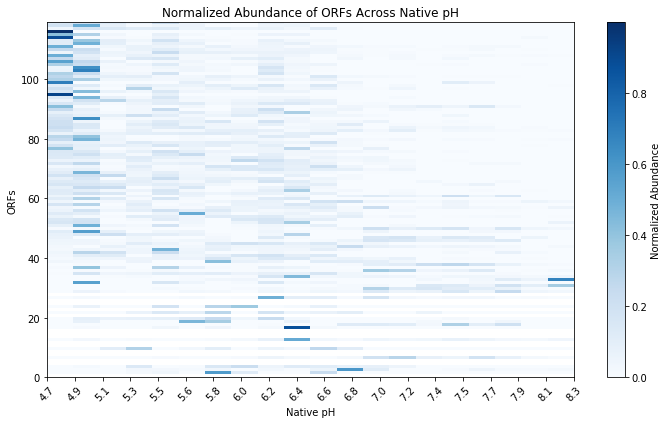

In [3]:
data = pd.read_csv("metagenomic_data/out/absolute_data_nar.tsv", sep='\t', header=None)
data = data.values
sorted_data = data[np.argsort(-np.abs(data[:, 0]))]
normalized_data = sorted_data / sorted_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('ORFs')
plt.title('Normalized Abundance of ORFs Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

## Construct Cluster ID Abundance vs Native pH plot 

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K00370')
ORF_list = list(ORFs)
print('\n ORFs \n')
print(ORF_list)
Cluster_IDs = ORF_list
for i in range(len(ORF_list)):
    Cluster_IDs[i] = find_cluster_from_orf(ORF_list[i])
    print(Cluster_IDs[i])
print('\n Clusters \n')
print(Cluster_IDs)
    

In [ ]:
IDs = np.array(Cluster_IDs)

sort_indices = np.argsort(-np.abs(data[:, 0])) 

sorted_data = data[sort_indices]
sorted_IDs = IDs[sort_indices]



In [ ]:

import numpy as np


# Dictionary to accumulate data
id_to_data = {} #given an id, the dictionary spits out the data array
for id, row in zip(sorted_IDs, sorted_data):
    if id in id_to_data:
        id_to_data[id] += row
    else:
        id_to_data[id] = row.copy()

# Reconstruct the arrays
unique_IDs = list(id_to_data.keys())
combined_data = np.array([id_to_data[id] for id in unique_IDs])

np.savetxt("metagenomic_data/out/cluster_ids.tsv", unique_IDs, delimiter = '\t', fmt = '%s')
np.savetxt("metagenomic_data/out/clustered_data_nar.tsv", combined_data, delimiter = '\t', fmt = '%0.6f')



In [58]:
cluster_IDs = pd.read_csv('metagenomic_data/out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('metagenomic_data/out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values
print(cluster_IDs)
print(clustered_data)

normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True) #normalization step

['T0.scaffold_610518454_c1_1', 'T0.scaffold_974243036_c1_1', 'T0.scaffold_51752605_c1_1', 'Soil14.scaffold_596019752_c1_119', 'T0.scaffold_519767388_c1_1', 'T0.scaffold_327279428_c1_4', 'T0.scaffold_273218771_c1_2', 'T0.scaffold_677904738_c1_1', 'T0.scaffold_967757664_c1_1', 'Soil5.scaffold_114379860_c1_1', 'Soil6.scaffold_604673340_c1_1', 'T0.scaffold_409096425_c1_1', 'T0.scaffold_82084267_c1_1', 'T0.scaffold_50999882_c1_2', 'T0.scaffold_61404940_c1_1', 'Soil3.scaffold_63658123_c1_64', 'Soil11.scaffold_594580914_c1_1', 'T0.scaffold_1146579158_c1_1', 'T0.scaffold_1087053736_c1_1', 'Soil3.scaffold_253488375_c1_4', 'Soil5.scaffold_416434691_c1_48', 'Soil6.scaffold_509384248_c1_7', 'T0.scaffold_287104333_c1_1', 'Soil14.scaffold_1008884942_c1_1', 'Soil9.scaffold_766455321_c1_2', 'Soil3.scaffold_31685847_c1_1', 'Soil5.scaffold_376523767_c1_1', 'Soil11.scaffold_437898375_c1_1', 'Soil5.scaffold_352638952_c1_1', 'Soil5.scaffold_342438982_c1_1', 'Soil6.scaffold_274716451_c1_1', 'Soil17.scaffold

/software/python-anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


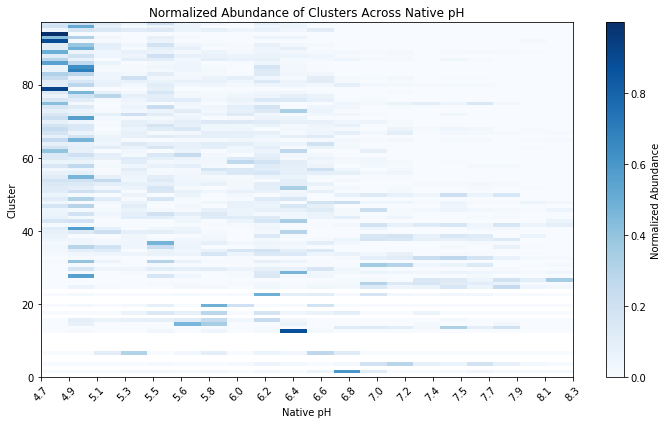

In [59]:

x = np.linspace(4.7, 8.3, 20)


plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Cluster')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

## PCA on plot above 

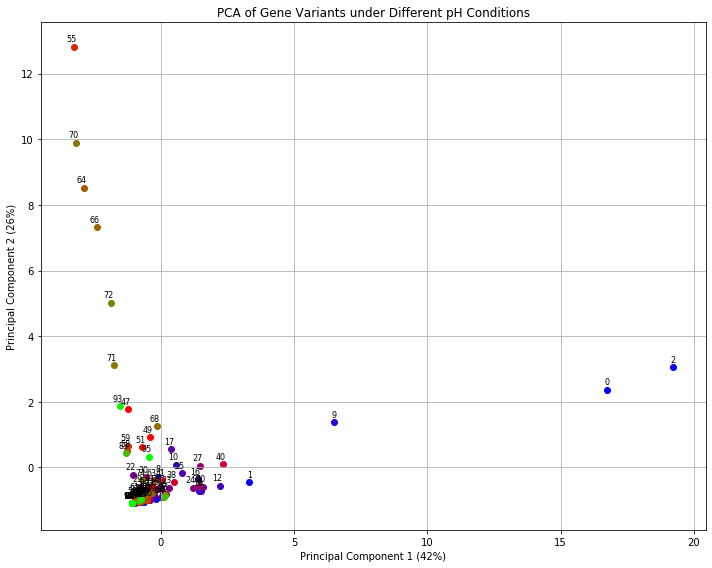

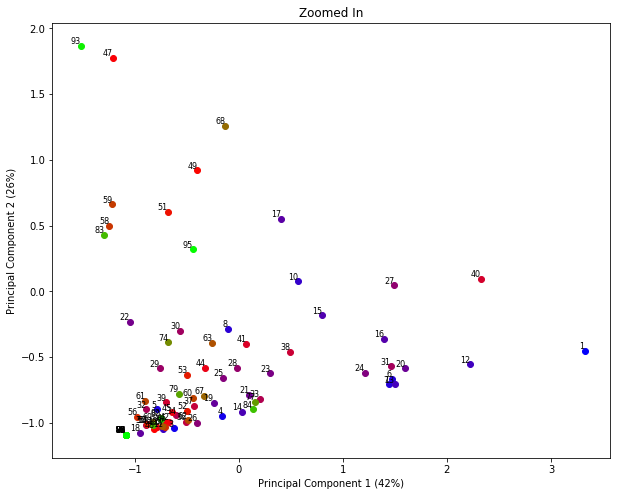

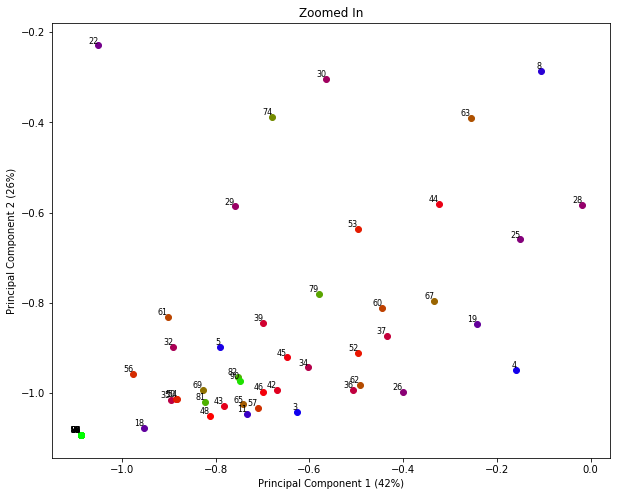

Principal Component 1: 42.17%
Principal Component 2: 26.19%


In [5]:


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustered_data = pd.read_csv('metagenomic_data/out/clustered_data_nar.tsv', sep='\t', header=None)
data = clustered_data.values 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)


# Generate colors based on row index
row_indices = np.arange(principal_components.shape[0])
colors = plt.cm.brg(row_indices / row_indices.max())

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
    plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')


plt.xlabel('Principal Component 1 (42%)')
plt.ylabel('Principal Component 2 (26%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()

#plot again but zoomed in


plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if principal_components[i, 0] < 5 and principal_components[i, 1] < 2:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
        plt.text(principal_components[i, 0], principal_components[i, 1], str(i), fontsize=8, ha='right', va='bottom')

plt.xlabel('Principal Component 1 (42%)')
plt.ylabel('Principal Component 2 (26%)')
plt.title('Zoomed In')
plt.show()

#plot again but zoomed in


plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if principal_components[i, 0] < 0 and principal_components[i, 1] < 0:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color=colors[i])
        plt.text(principal_components[i, 0], principal_components[i, 1], str(i), fontsize=8, ha='right', va='bottom')

plt.xlabel('Principal Component 1 (42%)')
plt.ylabel('Principal Component 2 (26%)')
plt.title('Zoomed In')
plt.show()

for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"Principal Component {i}: {ratio * 100:.2f}%")


## Construct Cluster ID vs Change in pH plot

The input of this will be a soil. It must be one of the soils that is actually perturbed. 

Then, given that soil sample, you immediately know the native pH and a set of perturbed pHs. We have metagenomic data for 11 (?) perturbed pHs per soil. We also have already collected the data for for T0 sample, which is the corresponding column in the data matrix above. 

First, gather the set of new pHs and new abundances for that sample. 

Note that there may be clusters not present in the T0 samples? But, we only want to consider the ones that are available at T0, so we can consider change.

perturbed soils are 3, 5, 6, 9, 11, 12, 14, 15, 16, 17

In [ ]:
#Soil3, 5, 6, 9, 11, 12, 14, 15, 16, 17
soil = 'Soil17'
print(perturbed_pHs(soil))
print(len(perturbed_pHs(soil)))

print(native_pH(soil))

print(samples_from_soils(soil))

In [ ]:
#For T9 and a specified soil (native pH), build a plot with rows which are cluster IDs and columns which are change in pH
soil = 'Soil3'

ORFs = find_orfs(get_filepath(soil, 'annotation'), 'K00370')

#Unique_IDs is the array, defined earlier, containing the list of cluster IDs

sample_list = samples_from_soils(soil)

metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
metadata = metadata.set_index('sample')


chunk_size = 100000

data = np.zeros((len(cluster_IDs), 11)) #data for plot stored here, each row is a dinstinct cluster

for chunk in pd.read_csv(get_filepath(soil, 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        if sample_id in sample_list:
            orf = filtered_chunk.iloc[i, 1]
            rel_abundance = filtered_chunk.iloc[i, 2]
            spikein = metadata.loc[sample_id, 'spikein_sum']
            cluster = find_cluster_from_orf(orf)
            if cluster in cluster_IDs:
                row_idx = cluster_IDs.index(cluster)
                col_idx = sample_list.index(sample_id)
                data[row_idx, col_idx] += rel_abundance/spikein
                print(rel_abundance/spikein)
        

In [ ]:
np.savetxt("metagenomic_data/out/soil3data.tsv", data, delimiter = '\t', fmt = '%0.6f')

In [12]:
soil3data = pd.read_csv("metagenomic_data/out/soil3data.tsv",sep='\t',header=None)
data = pd.read_csv("metagenomic_data/out/clustered_data_nar.tsv",sep='\t',header=None)
soil3data = soil3data.values
data = data.values

#extract data from first column for T0, so that we can really talk about change

#0 is special here, it is the index for soil3
soil = 'Soil3'

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']
index = soils.index(soil)
soil3_T0 = data[:, index]

print(len(data))

97


In [13]:
pHs = np.array(perturbed_pHs(soil))
sorted_indices = np.argsort(pHs)
sorted_pH = pHs[sorted_indices]
sorted_data = soil3data[:, sorted_indices]


In [14]:
print(sorted_pH)

change_in_pH = sorted_pH
nativepH = native_pH(soil)

for i in range(len(sorted_pH)):
    change_in_pH[i] = sorted_pH[i] - nativepH

[3.486 3.933 4.315 4.712 4.976 5.444 6.381 6.778 7.174 7.643 8.22 ]


In [15]:
change_in_abundance = sorted_data - soil3_T0[:,np.newaxis]

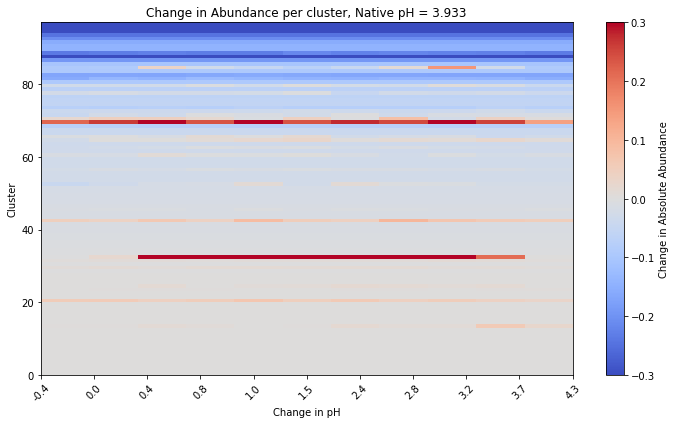

In [16]:
plt.figure(figsize=(10, 6))

x = change_in_pH

plt.imshow(change_in_abundance, aspect='auto', cmap='coolwarm', extent=[x[0], x[-1], 0, change_in_abundance.shape[0]], vmin = -0.3, vmax = 0.3)

plt.xlabel('Change in pH')
plt.ylabel('Cluster')
plt.title('Change in Abundance per cluster, Native pH = 3.933')

plt.colorbar(label='Change in Absolute Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

## Do PCA on plot above

## Construct scatter plot where x is peak native pH, y is peak perturbed pH, dots are cluster IDs

Steps:

1. function -- enriched_native_pH defined above now 
    input: cluster ID, filtered data matrix
    output: soil where it is most enriched (out of the 11)



2. function
    input: cluster ID and soil
    output: perturbed pH where it is most enriched, given it started in that soil 


In [ ]:
#first, filter the data 
#we only want rows which are actually perturubed
cluster_IDs = pd.read_csv('metagenomic_data/out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('metagenomic_data/out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values

#soils perturbed: 3, 5, 6, 9, 11, 12, 14, 15, 16, 17
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
data = clustered_data[:, selected]

print(len(data[0]))

print(enriched_native_pH(cluster_IDs[30], data, cluster_IDs))
print(samples_from_soils('Soil14'))



10


Given a cluster ID, we know the native pH where it is most enriched. Look at all of the perturbations which begin with that native pH, and identify which one of these it is most enriched in. 

In [ ]:

CID = cluster_IDs[30] #Cluster ID
soil = enriched_native_pH(CID, data, cluster_IDs)

#ORFs = find_orfs(get_filepath(soil, 'annotation'), 'K00370') #ORFs for the specified protein
ORFs = find_orfs_from_cluster(CID) #ORFs for the specified cluster

#Unique_IDs is the array, defined earlier, containing the list of cluster IDs

sample_list = samples_from_soils(soil)

metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
metadata = metadata.set_index('sample')

chunk_size = 100000

abundance = np.zeros(11) #for a given CID the specified soil, there are 11 perturbed samples

for chunk in pd.read_csv(get_filepath(soil, 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        if sample_id in sample_list:
            orf = filtered_chunk.iloc[i, 1]
            rel_abundance = filtered_chunk.iloc[i, 2]
            spikein = metadata.loc[sample_id, 'spikein_sum']
            idx = sample_list.index(sample_id)
            abundance[idx] += rel_abundance/spikein
            print(rel_abundance/spikein)

print(abundance)
    

## Testing functions

In [25]:
print(enriched_native_pH(cluster_IDs[30], data, cluster_IDs))
print(samples_from_soils('Soil14'))

Soil14
['Soil14_CE_251_N2_-2_None_T9', 'Soil14_CE_251_N2_-23_None_T9', 'Soil14_CE_251_N2_-5_None_T9', 'Soil14_CE_251_N2_-8_None_T9', 'Soil14_CE_251_N2_-90_None_T9', 'Soil14_CE_251_N2_0_None_T9', 'Soil14_CE_251_N2_14_None_T9', 'Soil14_CE_251_N2_2_None_T9', 'Soil14_CE_251_N2_22_None_T9', 'Soil14_CE_251_N2_5_None_T9', 'Soil14_CE_251_N2_9_None_T9']


In [ ]:
print(find_orfs(get_filepath('T0', 'annotation'), 'K00370'))

In [ ]:
print(find_orfs_from_cluster('Soil17.scaffold_502405353_c1_1'))

In [ ]:
print(find_cluster_from_orf('T0.scaffold_334770953_c1_1'))

In [ ]:
#Soil5, 6, 9, 11, 12, 14, 15, 16, 17
prefixes = ['T0', 'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

for prefix in prefixes:
    ORFS = find_clustered_orfs(get_filepath(prefix, 'annotation'), 'K00370')
    print(prefix, '\n')
    print(len(ORFS))
